https://www.strava.com/activities/3169231179/overview

In [19]:
import json

import pandas as pd
import geopandas as gpd
import fiona
import altair as alt
from vega_datasets import data
import folium
from folium.plugins import TimestampedGeoJson
import shapely

In [3]:
fname = "../data/_Onefootball_3_1_Exozet.gpx"

# Parse GPX data

In [4]:
fiona.listlayers(fname)

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

In [10]:
gdf_linestring = gpd.read_file(fname, layer="tracks")[['name', 'geometry']]

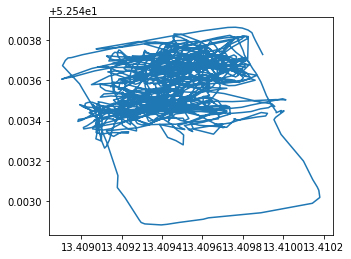

In [11]:
gdf_linestring.plot()

In [5]:
# https://geopandas.org/io.html#reading-spatial-data
gdf = (
    gpd.read_file(
        fname, layer="track_points"
    )[['track_seg_point_id', 'ele', 'time', 'geometry']]
    .rename(columns=dict(track_seg_point_id="id"))
    .set_index("id")
)
gdf["time"] = pd.to_datetime(gdf.time, format='%Y-%m-%dT%H:%M:%S').values.astype('int64') // 10 ** 6
gdf.dtypes

ele          float64
time           int64
geometry    geometry
dtype: object

In [6]:
meter_gdf = gdf.to_crs(epsg=3310)
gdf["distance"] = meter_gdf.distance(meter_gdf.shift())

In [7]:
gdf["style"] = len(gdf) * [dict(color="blue")]  # , marcker_icon="dot-circle"
gdf["icon"] = "circle"  # "fa-dot-circle"  # "Marker"  # "circle"  #  "dot-circle"

In [8]:
gdf["speed"] = gdf["distance"] / (gdf.time.diff() / 1_000)

In [9]:
gdf["two_minutes_break"] = (gdf['time'].diff() / 1_000) > 120

In [82]:
half1_start, half2_start = gdf.index[gdf['two_minutes_break'] == True].tolist()

In [84]:
gdf = gdf.loc[half1_start:]

# Altair Geoshape plot

Altair recipe:
- alt.Chart() => dataframe
- .mark_xx() => the kind of chart point
- .encode() => how to encode the data in the df for the chart
- .properties().interactive() => other properties, independent of data

In [85]:
position_plot = (
    alt
    .Chart(gdf)
    .mark_geoshape(
        stroke='white'
    )
    .encode(
        color=alt.Color('distance'),
    )
    .properties(
        width=600,
        height=500
    )
)
position_plot

alt.Chart(...)

**Note**: Altair doesn't support adding a basemap to a plot (because Vega-lite doesn't support it)

In [127]:
def timeseries_plot(y='distance_cage_1'):
    return (
        alt.Chart(gdf)
        .mark_line(
        )
        .encode(
            x=alt.X('time:T', axis=alt.Axis(format='%H:%M')),
            y=y,
        )
        .properties(
            width=700,
            height=100
        )
    )

timeseries_plot("speed")

alt.Chart(...)

In [87]:
alt.Chart(gdf).mark_tick().encode(
        x=alt.X('time:T', axis=alt.Axis(format='%H:%M')),
        y='two_minutes_break',
)

alt.Chart(...)

# Football pitch geometry and feature generation

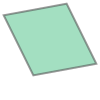

In [88]:
# https://osm.duschmarke.de/bbox.html
big_pitch_corners = [
    (13.40884, 52.54369),
    (13.40925, 52.54286),
    (13.41012, 52.54302),
    (13.40971, 52.54385),
]
big_pitch = shapely.geometry.Polygon(big_pitch_corners)
big_pitch

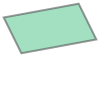

In [89]:
small_pitch_corners = [
    big_pitch_corners[0],
    shapely.geometry.LineString([big_pitch_corners[0], big_pitch_corners[1]]).centroid,
    shapely.geometry.LineString([big_pitch_corners[-1], big_pitch_corners[-2]]).centroid,
    big_pitch_corners[-1]
]
small_pitch = shapely.geometry.Polygon(small_pitch_corners)
small_pitch

In [91]:
cages = [
    shapely.geometry.LineString([small_pitch_corners[0], small_pitch_corners[1]]).centroid,
    shapely.geometry.LineString([small_pitch_corners[-1], small_pitch_corners[-2]]).centroid,
]

In [117]:
meter_gdf = gdf.to_crs(epsg=3310)
gdf["distance_cage_1"] = meter_gdf.distance(
    gpd.GeoSeries(cages[0], index=gdf.index, crs=gdf.crs).to_crs(epsg=3310)
)
gdf["distance_cage_2"] = meter_gdf.distance(
    gpd.GeoSeries(cages[1], index=gdf.index, crs=gdf.crs).to_crs(epsg=3310)
)

/Users/louis.guitton/workspace/football-strava/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/louis.guitton/workspace/football-strava/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [129]:
zoom = alt.selection_interval(bind='scales')
timeseries_plot("speed").add_selection(
    zoom
) & timeseries_plot("distance_cage_1").add_selection(
    zoom
) & timeseries_plot("distance_cage_2").add_selection(
    zoom
)

alt.VConcatChart(...)

# Time Series geo JSON

In [16]:
max_zoom = 18

In [124]:
# https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimestampedGeoJson
m = folium.Map(
    location=[gdf_linestring.centroid.y, gdf_linestring.centroid.x], 
    zoom_start=max_zoom,
    tiles='OpenStreetMap',
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

TimestampedGeoJson(
    data=gdf.to_json(),
    transition_time=80,
    period='PT5S',
    duration='PT20S',
    loop=False,
    auto_play=False,
    loop_button=True
).add_to(m)

# add pitch
folium.GeoJson(
    data=small_pitch,
    name="pitch",
    style_function= lambda x: dict(color='orange')
).add_to(m)
for c in cages:
    folium.Marker(
        location=[c.y, c.x],
        icon=folium.Icon(color='orange', icon='screenshot')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../data/timestamped_geojson_onefootball_game.html')
m

TODO:
- do a central symmetry for second half (or not)

# Bayesian HMM

In [130]:
import pymc3 as pm